In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary

import gym
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# for using sampling with gradient-tracking when selecting an action
# Categorical 함수는 확률 분포를 만들어주는 역할을 합니다. 좀 더 상세한 활용은 Agent 클래스의 select_action을 참고.
from torch.distributions import Categorical

In [2]:
class Policy(nn.Module):
    '''
        Action space가 Continous인 경우는 Policy network의 Output을 다르게 설정해주어야 합니다.
        더 자세한 사항은 Sutton의 Chap.13 의 13.7을 참고하거나,
        해당 github의 2. ContinousREINFORCE 노트북 파일을 보시면 continous action space에 대해 다루었습니다. 
    '''
    def __init__(self, input_dim, action_dim, hidden):
        '''
            State  dimension: input_dim
            Action dimension: action_dim
        '''
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden)
        self.fc2 = nn.Linear(hidden, action_dim)
        
    def forward(self, state):
        ''' 
            Input: State
            Output: Probability for each action. 
        '''
        out = F.relu(self.fc1(state)) 
        out = F.softmax(self.fc2(out), dim=1) # dim=1을 한 이유는, softmax를 action_dim에 맞춰줘야 하기 때문입니다. dim=0으로 하면 batch dimension에 softmax를 연산하게 됩니다.
        return out 

In [3]:
class Agent():
    def __init__(self, env, n_epi, max_steps, gamma, plot_freq, input_dim, action_dim, hidden, learning_rate, device, save_mode, model_name, saving_start_epi):
        # environment parameter
        self.gamma = gamma         # Reward의 Discount Rate 
        self.env = env             # 환경

        # trainig parameter
        self.device = device       # GPU 변수
        self.n_epi = n_epi         # 학습을 시킬 총 episode 횟수
        self.max_steps = max_steps # 한 episode당 maximum step의 횟수.    
        self.plot_freq = plot_freq # plotting을 하는 주기
        self.frame_cnt = 0         # 매 스텝마다 1씩 추가되는 변수. total training frame을 카운트 하는 변수.

        # network paramter
        self.lr = learning_rate
        self.policy = Policy(input_dim, action_dim, hidden).to(self.device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=self.lr)
        
        # log parameter
        self.scores = []
        self.losses = []
        self.avg = []
        self.save_mode = save_mode
        self.model_name = model_name
        self.saving_start = saving_start_epi
        
    def select_action(self, state):
        '''
            Discrete action space에서 action을 뽑는 함수.
            Categorical 함수를 쓰는 이유(미분가능)는 아래의 pytorch 공식 홈페이지 설명을 한번쯤 읽어보시길 추천합니다.
            https://pytorch.org/docs/stable/distributions.html
        '''
        
        prob = self.policy(torch.FloatTensor(state).view(1, -1).to(self.device)) 
        cate_dist = Categorical(prob) # cate_dist는 prob을 반영한 확률 함수
        action = cate_dist.sample()   # cate_dist의 분포에서 action을 sampling.
        return action.item(), cate_dist.log_prob(action), prob.detach().cpu().numpy() # prob을 return하는 이유는 개인적으로 plotting해보고 싶어서 넣은 것이고 학습에는 필요없습니다.
    
    def train(self):
        '''
            환경과 상호작용을 통해 agent를 학습시키는 함수. 위에서 정의되어진 함수들이 이곳에서 쓰입니다.
        '''
        self.scores = [] # plot을 위한 score 저장
        self.losses = [] # plot을 위한 loss 저장
        
        for i_episode in range(1, self.n_epi+1):
            epi_history = [] # agent의 행동에 의한 reward, log_probabilty 등을 저장. update network에서 쓰인다.
            rewards = [] 
            score = 0

            state = self.env.reset() # Get the initial state from the environment
            for step in range(self.max_steps): 
                action, log_prob, prob = self.select_action(state) # action을 선택 후 다음 줄에서 env에 넣어 환경으로 부터 feedback을 받습니다.
                next_state, reward, done, _ = env.step(action)
                
                epi_history.append([log_prob, reward])  # update를 위한 reward와 log probabilty(= log(policy))를 저장
                state = next_state
                score += reward
                self.frame_cnt += 1
                if done: break
                    
            self.scores.append(score)
            loss = self._update_policy(epi_history)
            self.losses.append(loss)
            if i_episode%self.plot_freq == 0: # 주기마다 plot.
                self._plot_status(i_episode, self.losses, self.scores)

            if self.save_mode & (i_episode > self.saving_start): self._save_model()
            self.avg.append(np.mean(self.scores[-10:]))

    def test(self, model_path):
        ''' 저장된 pt파일을 불러와 test 합니다 '''
        
        self.policy.load_state_dict(torch.load(model_path))
        self.policy.eval()
        
        state = self.env.reset()
        done = False
        score = 0
        accum_frames = []
        while not done:
            accum_frames.append(self.env.render(mode="rgb_array"))
            action, log_prob, prob  = self.select_action(state)
            next_state, reward, done, _ = self.env.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        return accum_frames
        
    def _update_policy(self, epi_history):
        '''
            기본 REINFORCE, Baseline, Actor-Critic의 핵심 algorithm이 반영된 함수.
        '''
        
        accum_R = 0  # 누적 reward를 계산하는 변수    
        loss = 0   
        epi_len = len(epi_history) - 1 # policy network을 update할 때, 앞에 gamma^t 부분을 계산하기 위한 변수입니다. 아래 gamma_powers 변수 참고.

        for idx, [log_p, r] in enumerate(epi_history[::-1]):
            
            accum_R = r + (self.gamma * accum_R)
            gamma_pow_t = self.gamma**(epi_len-idx) # gamma^t
            one_step_loss = -log_p * gamma_pow_t * accum_R  # sutton 책의 REINFORCE pseudo code 반영. Chapter.13.3
            loss += one_step_loss
        
        # 참고: REINFORCE의 sutton 책은 매 step마다 update를 하므로, 
        # 원래는 zero_grad()부터 .step()까지의 3줄이 위의 for문 안에 있어야 합니다. 다만, 이렇게하면 좀 더 expected 값에 가까워진 loss가 아닐까 생각해봅니다. 
        # For문에 넣는지 여부와, gamma, learning rate 등을 변화시키는 것등 다양하게 돌려보시길 추천합니다!
        self.optimizer.zero_grad()  # 미분값을 0으로 초기화
        loss.backward()             # 미분값 구하기
        self.optimizer.step()       # Gradient Decent로 update하기.
        
        return loss.item() 
        # plot하기 위해서 loss를 리턴합니다. .item()을 하는 이유는 .detach()처럼 미분그래프를 끊어주기 위함입니다. 
    
    def _save_model(self):
        last_mean = np.mean(self.scores[-10:])
        if  max(self.avg) < last_mean:
            torch.save(self.policy.state_dict(), self.model_name+f'Score_{round(last_mean, 3)}.pt')
            
    def _plot_status(self, i_episode, loss_hist, score_hist):
        subplot_params = [
            (121, f"Scores in episode_{i_episode}", score_hist),
            (122, f"Policy loss in episode:{i_episode}", loss_hist),
        ]

        clear_output(True)
        plt.figure(figsize=(10, 5), facecolor='w')
        for loc, title, values in subplot_params:
            plt.subplot(loc)
            plt.title(f'Frame:{self.frame_cnt} '+title)
            plt.plot(values)
        plt.show() 

In [ ]:
device = torch.device(
            "cuda:1" if torch.cuda.is_available() else "cpu"
        ) # GPU가 있다면 cuda를 잡겠지만 없다면 cpu를 사용하게끔 조건문이 되어있습니다. cuda: 뒤에 있는 번호는 GPU 카드의 번호입니다. 1장인 경우는 그냥 숫자를 안쓰거나 0번으로 하면 됩니다.

env_name_list = ["CartPole-v0", "CartPole-v1", "MountainCar-v0", "LunarLander-v2"]
env_name = env_name_list[0]
env = gym.make(env_name)

# 몇 episode 이후부터 저장할 것인지 정하는 변수 입니다.
saving_start_epi = 100

# model을 저장할 폴더를 지정합니다. save_mode 변수로 저장 여부를 결정합니다.
save_mode = True
model_save_folder = './model_save'
if not os.path.exists(model_save_folder):
    os.mkdir(model_save_folder)
model_name = f"./{model_save_folder}/Discrete_REINFORCE_{env_name}_"

# env를 선언하고 state dimension과 action dimension을 뽑아오는 것. Gym Atari 환경에 한정된 코드.
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

print("Environment: ", env_name)
print("State Dimension:", state_dim, " Action Dimension:", action_dim)

# 위에서 설명되었던 hyper parameter 설정. 가장 민감한 것은 learning rate이며, gamma도 학습에 영향을 크게 미칠때가 많습니다.
n_epi = 100000 
max_steps = 900
gamma = 0.99
plot_freq = 10

hidden = 32
learning_rate = 0.008

In [5]:
agent = Agent(
            env,
            n_epi,
            max_steps,
            gamma,
            plot_freq,
            state_dim,
            action_dim,
            hidden,
            learning_rate,
            device,
            save_mode,
            model_name,
            saving_start_epi) 

In [ ]:
agent.train() 

In [ ]:
# 모델을 test하고 게임 플레이한 결과를 배열로 저장합니다.

model_path = f"./{model_save_folder}/Discrete_REINFORCE_CartPole-v0_Score_200.0.pt"
frames = agent.test(model_path)

In [ ]:
# 위의 배열로 저장한 것을 test.mp4 파일을 만들고 재생합니다. 
# 배열을 재생시키는 방법은 여러가지가 있습니다. 만일, 

import imageio
from IPython.display import Video
imageio.mimwrite('./test.mp4', frames, fps=30) # 
Video('./test.mp4', width=480, height=360)

    LunarLander 결과
    
    n_epi = 100000 
    max_steps = 900
    gamma = 0.95
    plot_freq = 10

    hidden = 128
    learning_rate = 0.0008

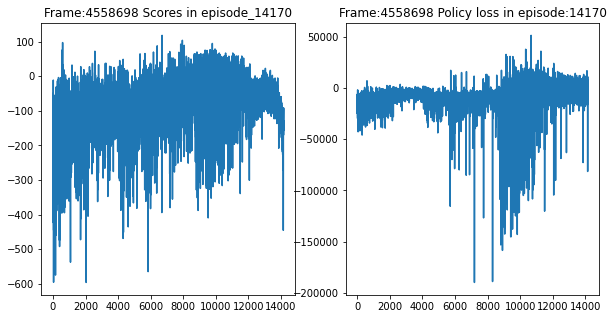

    LunarLander 결과
    
    n_epi = 100000 
    max_steps = 500
    gamma = 0.95
    plot_freq = 10

    hidden = 128
    learning_rate = 0.002

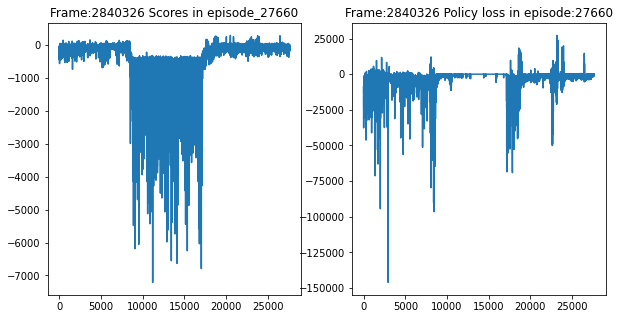

    LunarLander 결과
    
    n_epi = 100000 
    max_steps = 500
    gamma = 0.95
    plot_freq = 10

    hidden = 128
    learning_rate = 0.006

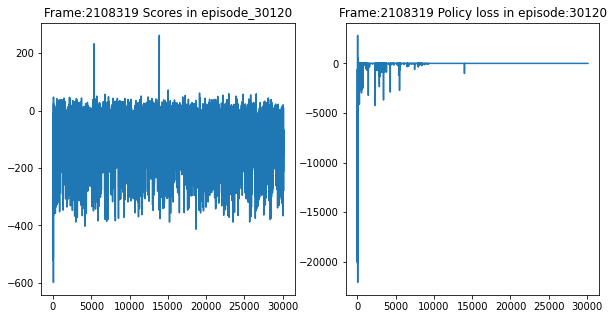